<center><span style="font-size: 40px; color: #21918c; font-weight: bold;">WiDS Datathon++ 2024 University Challenge</span></center>

<center><span style="font-size: 40px; color: black; font-weight: bold;">Equity in Healthcare</span></center>


**Students:**                                                                     

* Ioana Bîrlan                                                                  
* Bianca Conțolencu
* Ana Oprea
* Gianina Petrașcu



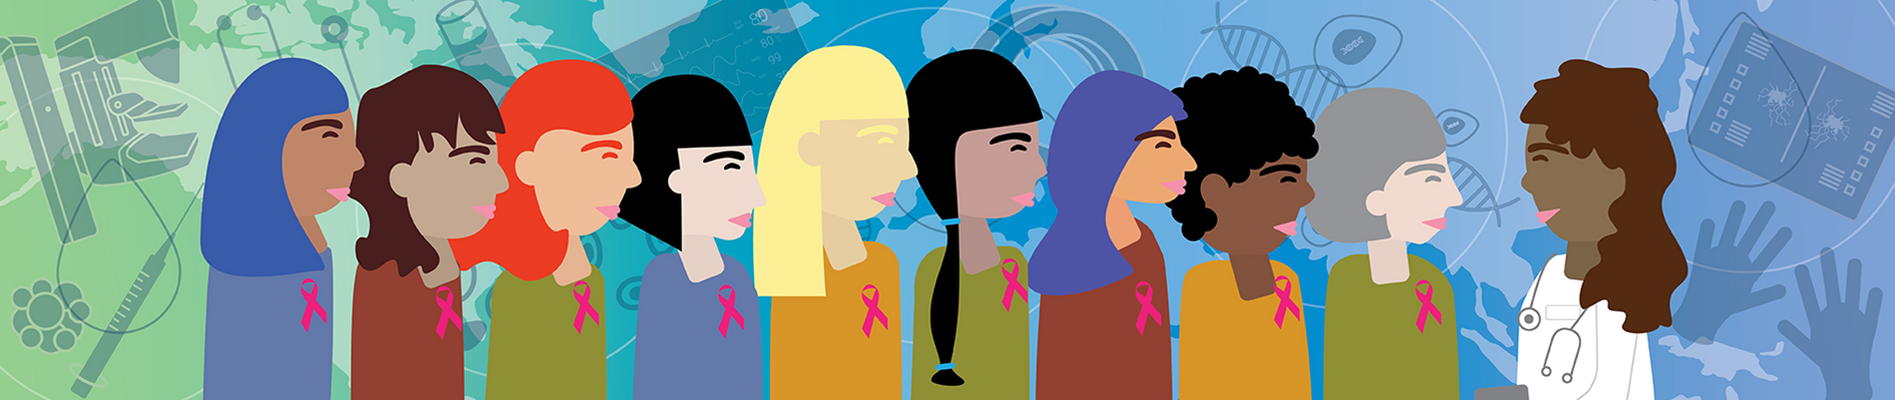

<h1 id="loading">
<span style= "color: #21918c; font-weight: bold;">Import libraries</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install pycaret
!pip install category_encoders

In [ ]:
class color_class:
    BOLD_COLOR = '\033[1m' + '\033[93m'
    BOLD = '\033[1m'
    END = '\033[0m'

print(color_class.BOLD_COLOR + '\nImporting all the required libraries....\n\n'+ color_class.END)
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeRegressor 
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display_html
import pandas as pd
from pycaret.regression import *
from category_encoders.target_encoder import TargetEncoder
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer


%matplotlib inline
print(color_class.BOLD_COLOR + '\nDone!\n\n'+ color_class.END)

In [ ]:
def reduce_mem_usage(dataframe, verbose=True):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  start_memory = dataframe.memory_usage().sum() / 1024**2
  for col in dataframe.columns:
    col_type = dataframe[col].dtypes
    if col_type in numerics:
      c_min = dataframe[col].min()
      c_max = dataframe[col].max()
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          dataframe[col] = dataframe[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          dataframe[col] = dataframe[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          dataframe[col] = dataframe[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          dataframe[col] = dataframe[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          dataframe[col] = dataframe[col].astype(np.float32)
        else:
          dataframe[col] = dataframe[col].astype(np.float64)
  end_memory = dataframe.memory_usage().sum() / 1024**2
  print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_memory, 100 * (start_memory - end_memory) / start_memory)) if verbose else print('Reduced to {:5.2f}'.format(end_memory))
  return dataframe

In [ ]:
# read dataset
train = pd.read_csv('/kaggle/input/widsdatathon2024-university/train.csv')
test = pd.read_csv('/kaggle/input/widsdatathon2024-university/test.csv')
sample = pd.read_csv('/kaggle/input/widsdatathon2024-university/SampleSolution.csv')

In [ ]:
train

In [ ]:
test

<h1 id="loading">
<span style= "color: #21918c; font-weight: bold;">Variable characteristics</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [ ]:
print(train.info())
print(test.info())

In [ ]:
##Nulls per column train
for column in train.columns:
    null_count = train[column].isnull().sum()
    if null_count > 0:
        percent_nulls = (null_count / train.shape[0]) * 100
        print(f'{column} : {percent_nulls:.2f}% nulls')

In [ ]:
##Nulls per column test
for column in test.columns:
    null_count = test[column].isnull().sum()
    if null_count > 0:
        percent_nulls = (null_count / train.shape[0]) * 100
        print(f'{column} : {percent_nulls:.2f}% nulls')

<h1 id="expl">
<span style= "color: #21918c; font-weight: bold;">Exploratory Analysis</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [ ]:
colors= ['#21918c']
stats_df = train.drop(columns  = ['patient_id']).describe().T.reset_index().rename(columns = {'index':'Features'})
stats_df['count'] = stats_df['count'].astype(int)


style = stats_df.style.set_table_attributes("style='display:inline'").\
                                bar(subset = ['mean', 'std', 'min', '25%','50%','75%', 'max'],axis = 1 ,color = colors[0])\
                                .format({
                                         'mean':"{:20,.3f}", 
                                         'std':"{:20,.3f}", 
                                         'min':"{:20,.3f}", 
                                         '25%':"{:20,.3f}",
                                         '50%':"{:20,.3f}",
                                         '75%':"{:20,.3f}", 
                                         'max':"{:20,.3f}"})\
                                .format({"Features": lambda x:  x.upper()},
                                 )\
                                .set_properties(**{'background-color': 'white',                                                   
                                    'color': 'black'})
print(color_class.BOLD_COLOR + '''\n Descriptive Statistics of The Dataset \
\n''' + color_class.END)

display_html(style._repr_html_(), raw=True)

In [ ]:
# Create box plot using seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='patient_race', y='treatment_pd', data=train, palette='viridis')

# Calculate and annotate with median values
medians = train.groupby('patient_race')['treatment_pd'].median().sort_values(ascending=False)
median_labels = [f'{med:.2f}' for med in medians]

# Add annotations for medians
for tick, label in zip(range(len(medians)), plt.gca().get_xticklabels()):
    plt.text(tick, medians[tick] + 0.5, median_labels[tick],
             horizontalalignment='center', size='medium', color='white', weight='semibold')

# Set plot title and labels
plt.title('Distribution of Treatment Period by Races', fontsize=16)
plt.xlabel('Patient Race', fontsize=14)
plt.ylabel('Treatment Period', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('box plot.png')
plt.show()


In [ ]:
# Create box plot using seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(x='payer_type', y='treatment_pd', data=train, palette='viridis')

# Calculate and annotate with median values
medians = train.groupby('payer_type')['treatment_pd'].median().sort_values(ascending=False)
median_labels = [f'{med:.2f}' for med in medians]

# Add annotations for medians
for tick, label in zip(range(len(medians)), plt.gca().get_xticklabels()):
    plt.text(tick, medians[tick] + 0.5, median_labels[tick],
             horizontalalignment='center', size='medium', color='white', weight='semibold')

# Set plot title and labels
plt.title('Distribution of Treatment Period by Payer type', fontsize=16)
plt.xlabel('Payer Type', fontsize=14)
plt.ylabel('Treatment Period', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('box plot_payer.png')
plt.show()


<h1 id="traintest">
<span style= "color: #21918c; font-weight: bold;"> Distribution of Independent Variables: Train vs. Test</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [ ]:
# Select numerical variables from train dataset
numerical_columns = train.select_dtypes(include=np.number).columns

# Set up subplots for the original data and imputed data
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(15, 5 * len(numerical_columns)))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Plot train data distribution
for i, column in enumerate(numerical_columns):
    sns.histplot(data=train, x=column, kde=True, ax=axes[i, 0], bins=30)
    axes[i, 0].set_title(f'Train Distribution of {column}')
    axes[i, 0].set_xlabel(column)

# Plot test data distribution
for i, column in enumerate(numerical_columns):
    # Exclude 'treatment_pd' from the test DataFrame
    if column != 'treatment_pd':
        sns.histplot(data=test, x=column, kde=True, ax=axes[i, 1], bins=30, color="#21918c")
        axes[i, 1].set_title(f'Test Distribution of {column}')
        axes[i, 1].set_xlabel(column)

# Show the plots
plt.show()

<h1 id="target">
<span style= "color: #21918c; font-weight: bold;">Variables Correlated with the Target Variable 'treatment_pd'</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [ ]:
corr_variables = train[numerical_columns].corr()
corr_variables

In [ ]:
corr = corr_variables[['treatment_pd']].abs().sort_values(by='treatment_pd', ascending=False)
corr

In [ ]:
# Create a heatmap for the absolute correlation matrix
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr.sort_values(
    by='treatment_pd', ascending=False), annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Absolute Correlation Heatmap\n', loc='center', fontsize=18)
plt.show()

<h1 id="distr">
<span style= "color: #21918c; font-weight: bold;">Distribution of the Target Variable</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# Plot histogram
sns.histplot(data=train, x='treatment_pd', kde=True, ax=axes, bins=30, color="#21918c")

# Set labels and title
axes.set_ylabel("Frequency")
axes.set_title("Distribution of treatment_pd")
axes.set_xlabel("treatment_pd")

# Center the graph by setting x-axis limits
axes.set_xlim(train['treatment_pd'].min(), train['treatment_pd'].max())

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
!pip install folium
!pip install keplergl
!pip install pgeocode

In [ ]:
train['patient_zip3']

In [ ]:
from keplergl import KeplerGl
import pgeocode

nomi = pgeocode.Nominatim('us')
a = nomi.query_postal_code(list(train['patient_zip3'].astype(str)+"01"))
df_location = pd.concat([train['treatment_pd'],a[['latitude','longitude']]],axis=1)

In [ ]:
df_location

In [ ]:
df_map = df_location.groupby(['latitude','longitude']).mean().reset_index()
df_map=df_map.rename(columns={'treatment_pd':'average'})
df_map

In [ ]:
# Find the top 3 minimum and maximum values with their coordinates
top_min = df_map.nsmallest(4, 'average')
top_max = df_map.nlargest(4, 'average')

# Display the results
print("Top 3 Minimum Values:")
print(top_min[['latitude', 'longitude', 'average']])

print("\nTop 3 Maximum Values:")
print(top_max[['latitude', 'longitude', 'average']])

In [ ]:
import folium
from folium.plugins import HeatMap
# Create a folium map centered around the mean latitude and longitude
m = folium.Map(location=[df_map['latitude'].mean(), df_map['longitude'].mean()], zoom_start=4)

# Define a function to choose color based on the average value
def get_color(value):
    if value < 100:
        return 'green'
    elif value < 200:
        return 'orange'
    else:
        return 'red'

# Add CircleMarkers to the map
for idx, row in df_map.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=7,
        color=get_color(row['average']),
        fill=True,
        fill_color=get_color(row['average']),
        fill_opacity=0.6,
        popup=f'Average: {row["average"]}'
    ).add_to(m)

# Display the map
m

# **Applying NLP to breast_cancer_diagnosis_desc Column**

In [ ]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud

In [ ]:

# Text preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply text preprocessing
train.loc[:,'breast_cancer_diagnosis_desc'] = train['breast_cancer_diagnosis_desc'].apply(preprocess_text)

# Replace abbreviations with full form
train.loc[:,'breast_cancer_diagnosis_desc'] = train['breast_cancer_diagnosis_desc'].replace({
    r'\bmalig\b': 'malignant',
    r'\bunsp\b': 'unspecified',
    r'\bovrlp\b': 'overlapping',
    r'\bneoplm\b': 'neoplasm'
}, regex=True)

In [ ]:
# Function to generate word cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Join all preprocessed text into a single string for word cloud generation
all_text = ' '.join(train['breast_cancer_diagnosis_desc'].values)

# Generate and display the word cloud
generate_wordcloud(all_text)

 <h1 id="multicol">
<span style= "color: #21918c; font-weight: bold;">Multicollinearity Analysis</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = train[numerical_columns].corr()

threshold = 0.5  

# Create a mask for the upper triangle of the correlation matrix
mask = abs(corr) >= threshold

plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix with annotations
sns.heatmap(corr, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 8}, mask=mask)

plt.show()

In [ ]:
corr_df = train.drop(['patient_id'],axis=1).select_dtypes(exclude='object').corr()

corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=0)
corr_df = corr_df[abs(corr_df)>0.005].dropna(how='any',axis=1)

# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = train[considered_features].dropna()
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# features to consider removing
considered_features = list(corr_df.index)

# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

 <h1 id="sol">
<span style= "color: #21918c; font-weight: bold;">Solutions</span>
<a class="anchor-link" href="">¶</a>
</h1>

<h3 id="s1">
<span style= "color: #21918c; font-weight: bold;">1st Solution</span>
<a class="anchor-link" href="">¶</a>
</h1>

## Models from the PyCaret Library

**PyCaret** is a library for automating the machine learning process in Python. It offers a set of high-level functions to quickly and efficiently carry out various tasks related to machine learning and data science. Its main advantage is that it simplifies many of the routine operations in this domain, enabling users to perform complex tasks with less code and in a shorter amount of time.

**Key features** of PyCaret include:

* **Automatic Data Preprocessing**: PyCaret can automate many of the tedious data preprocessing tasks, such as handling missing values, encoding categorical variables, and scaling data. It can automatically manage missing values in the dataset, either by removing records or features with missing values or by replacing them with relevant statistics (such as the mean or median). For time series datasets, PyCaret can perform imputations through interpolation, using preceding and/or subsequent values to calculate and fill missing values. PyCaret can also scale and normalize data and includes options for feature reduction using techniques like Principal Component Analysis (PCA) or Linear Discriminant Analysis (LDA). It applies various mathematical transformations (logarithmic, exponential, etc.) to modify the distribution of features.

* **Model Selection and Comparison**: It allows users to quickly compare different models to identify the best performance for a given dataset.

* **Hyperparameter Optimization**: PyCaret includes functionalities for automatic hyperparameter tuning, helping to improve model performance.

* **Model Analysis and Interpretation**: It provides tools for analyzing models and interpreting results, including generating plots and reports.

* **Machine Learning Pipelines**: It facilitates the creation and deployment of machine learning pipelines, which include preprocessing, model selection, optimization, and deployment.

* **Ease of Use**: One of PyCaret's main advantages is its ease of use, allowing even those without deep experience in machine learning to build efficient models.


In [ ]:
# Stacking train and test datasets together vertically
whole = pd.concat([train, test], axis=0)

# Creating indicators for missing variables
whole_with_indicator = whole.copy()
for col in whole.columns[:-1]:
    whole_with_indicator[col + '_is_missing'] = whole[col].isnull().astype(int)

# Dropping zero variance columns
df = whole_with_indicator.loc[:, (whole_with_indicator != whole_with_indicator.iloc[0]).any()]

# Finding categorical columns in the dataset
cat_cols = train.select_dtypes(exclude='number').columns

# Target-encoding categorical columns
TE_encoder = TargetEncoder()
train_te = TE_encoder.fit_transform(train[cat_cols], train['treatment_pd'])
test_te = TE_encoder.transform(test[cat_cols])

# Dropping old categorical columns and concatenating the original datasets with the encoded columns
train.drop(cat_cols, axis=1, inplace=True)
test.drop(cat_cols, axis=1, inplace=True)
train_new = pd.concat([train, train_te], axis=1)
test_new = pd.concat([test, test_te], axis=1)

# Setting up a PyCaret regression experiment
exp_reg = setup(data=train_new, target='treatment_pd', session_id=123)

compare_models()

# Select the best performing regression model (e.g., Gradient Boosting Regressor)
best_model = create_model('gbr')

# Tune hyperparameters of the selected model
tuned_model = tune_model(best_model)

# Make predictions for the train dataset
pred_train = predict_model(tuned_model)

# Make predictions for the test dataset
pred_test = predict_model(tuned_model, data=test_new)

In [ ]:
pred_test.columns

In [ ]:
# Extract the regression predictions (score) for the test dataset
score = pred_test['prediction_label']

score.value_counts()

In [ ]:
submission_pycaret = sample.copy()
submission_pycaret['treatment_pd'] = score

In [ ]:
# Save the DataFrame as a CSV file
submission_pycaret.to_csv('pycaret_submission.csv', index=False)

<h3 id="s2">
<span style= "color: #21918c; font-weight: bold;">2nd Solution</span>
<a class="anchor-link" href="">¶</a>
</h1>

### <font color='teal'>Handling Missing Values </font>
### <font color='brown'>KNN Imputation for Numeric Variables </font> 

Fancyimpute uses machine learning algorithms to impute missing values. It utilizes the entire column to perform the imputation. There are two methods for imputing missing data using Fancyimpute:

**KNN (K-Nearest Neighbors)**: This method imputes missing values by weighting samples based on the mean squared differences of existing feature values and their closest neighbors. We used the 5 nearest neighbors (K=5) that have a particular feature to fill in the missing values.

In [ ]:
# read dataset
train = pd.read_csv('/kaggle/input/widsdatathon2024-university/train.csv')
test = pd.read_csv('/kaggle/input/widsdatathon2024-university/test.csv')
sample = pd.read_csv('/kaggle/input/widsdatathon2024-university/SampleSolution.csv')

In [ ]:
!pip install fancyimpute

from fancyimpute import KNN


# Check if there are still any missing values
missing_values_before_imputation = train[numerical_columns].isnull().sum()
print(f"Number of missing values before imputation: {missing_values_before_imputation}")

# Impute missing values using KNN, excluding non-numeric columns
knn_train_imputed = pd.DataFrame(KNN(k=5).fit_transform(train[numerical_columns]), columns=numerical_columns)

# Check if there are still any missing values
missing_values_after_imputation = knn_train_imputed.isnull().sum()
print(f"Number of missing values after imputation: {missing_values_after_imputation}")

In [ ]:
numerical_columns1 =test.select_dtypes(include=np.number).columns

missing_values_before_imputation = test[numerical_columns1].isnull().sum()
print(f"Number of missing values before imputation: {missing_values_before_imputation}")

knn_test_imputed = pd.DataFrame(KNN(k=5).fit_transform(test[numerical_columns1]), columns=numerical_columns1)

missing_values_after_imputation = knn_test_imputed.isnull().sum()
print(f"Number of missing values after imputation: {missing_values_after_imputation}")

### <font color='brown'>  Distribution of Numeric Variables Before and After KNN Imputation </font>

In [ ]:
# Set up subplots for the original data and imputed data
fig, axes = plt.subplots(nrows=len(numerical_columns), ncols=2, figsize=(15, 5 * len(numerical_columns)))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Plot original distribution
for i, column in enumerate(numerical_columns):
    sns.histplot(data=train, x=column, kde=True, ax=axes[i, 0], bins=30)
    axes[i, 0].set_title(f'Original Distribution of {column}')
    axes[i, 0].set_xlabel(column)

# Plot distribution after imputation
for i, column in enumerate(numerical_columns):
    sns.histplot(data=knn_train_imputed, x=column, kde=True, ax=axes[i, 1], bins=30, color="#21918c")
    axes[i, 1].set_title(f'Imputed Distribution of {column}')
    axes[i, 1].set_xlabel(column)

plt.show()

### <font color='brown'>  Encoding Categorical Variables Using OneHotEncoder </font> 

**One-Hot Encoding** works by transforming each category of a categorical feature into its own binary feature.

handle_unknown='ignore' => When an unknown category is encountered during transformation, the resulting one-hot encoded columns for this feature will all be zeros. During inverse transformation, an unknown category will be assigned as None.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def cat_encode(train, test, cat_columns):
    # Initialize the encoder
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    for column in cat_columns:
        # Fit and transform on the training set
        train_encoded = ohe.fit_transform(train[[column]])

        # Transform the test set
        test_encoded = ohe.transform(test[[column]])

        # Drop the original categorical column
        train = train.drop([column], axis=1)
        test = test.drop([column], axis=1)

        # Create DataFrames from the encoded arrays with column names
        train_encoded = pd.DataFrame(train_encoded, columns=ohe.get_feature_names_out([column]))
        test_encoded = pd.DataFrame(test_encoded, columns=ohe.get_feature_names_out([column]))

        # Concatenate the original DataFrame and the encoded DataFrame
        train = pd.concat([train, train_encoded], axis=1)
        test = pd.concat([test, test_encoded], axis=1)

    return train, test

In [ ]:
# Add categorical columns back to cc_train_imputed
categorical_columns = train.select_dtypes(exclude=np.number).columns
knn_train_imputed[categorical_columns] = train[categorical_columns]

# Add categorical columns back to cc_test_imputed
categorical_columns_test = test.select_dtypes(exclude=np.number).columns
knn_test_imputed[categorical_columns_test] = test[categorical_columns_test]

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

cat_features = knn_train_imputed.select_dtypes(exclude=numerics)
cat_features_test = knn_test_imputed.select_dtypes(exclude=numerics)

categorical_columns = ['patient_race','payer_type','patient_state','patient_gender','breast_cancer_diagnosis_code','breast_cancer_diagnosis_desc','metastatic_cancer_diagnosis_code','metastatic_first_treatment','metastatic_first_treatment_type','metastatic_first_novel_treatment','metastatic_first_novel_treatment_type','region','division']

KNN_OHE_train_imputed, KNN_OHE_test_imputed = cat_encode(knn_train_imputed, knn_test_imputed, categorical_columns)

In [ ]:
KNN_OHE_train_imputed

In [ ]:
def filter_na_cols(df):
    count_na_df = df.isna().sum() 
    if count_na_df[count_na_df > 0].tolist():
        return count_na_df[count_na_df > 0]
    else:
        return 'Clean dataset'

In [ ]:
filter_na_cols(KNN_OHE_train_imputed)

In [ ]:
filter_na_cols(KNN_OHE_test_imputed)

In [ ]:
import re

def encode_feature_names(features):
    encoded_features = []
    for feature in features:
        # Replace special characters with underscores
        feature = re.sub(r'[^a-zA-Z0-9]', '_', feature)
        # Add a prefix to the feature name to ensure it starts with a letter
        feature = 'f_' + feature if feature[0].isdigit() else feature
        encoded_features.append(feature)
    return encoded_features

In [ ]:
KNN_OHE_train_imputed.columns = encode_feature_names(KNN_OHE_train_imputed.columns)
KNN_OHE_test_imputed.columns = encode_feature_names(KNN_OHE_test_imputed.columns)

**MinMaxScaler** normalizes data to a range of [0, 1]. This is useful when the data distribution is not Gaussian or when maintaining the relationships between variable values is desired. However, it is sensitive to outliers, as they can distort the range of the data.

On the other hand, **StandardScaler** standardizes data to have a mean of zero and a variance of one. This technique is beneficial when the data distribution is Gaussian and we want to compare variables with different units or scales. It is less sensitive to outliers compared to MinMaxScaler.

In summary, MinMaxScaler is preferable when you want to preserve the relationships between variables, while StandardScaler is better suited for comparing variables with different units or scales.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

def feature_engineering(origin_train, origin_test):
    train, test = origin_train, origin_test
    irrelevant_cols = ['patient_id','treatment_pd']
    features = [col for col in train.columns if col not in irrelevant_cols]
    X = train[features]
    X_test = test[features]
    y = train['treatment_pd']
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler to the train data
    scaler.fit(X)
    # Transform the train data
    X_train_scaled = scaler.transform(X)

    # Transform the test data
    X_test_scaled = scaler.transform(X_test)
    
    return X, y, X_test

In [ ]:
# Split the data into training and test sets
X, y, X_test = feature_engineering(KNN_OHE_train_imputed.copy(), KNN_OHE_test_imputed.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Identify correlated features to drop that fall above a correlation threshold 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [ ]:
#used 80,85,90 -> best score with 95

features_to_drop = identify_correlated(KNN_OHE_train_imputed, .95) 

In [ ]:
print(color_class.BOLD_COLOR + f'\nNumber of features to drop.... {len(features_to_drop)}\n' + color_class.END)

print(features_to_drop)

In [ ]:
remove_feature = ['patient_id', 'treatment_pd']
features_to_drop_v1 = [ele for ele in features_to_drop if ele not in remove_feature]
features_to_drop_v1


In [ ]:
cc_train_reduced = pd.DataFrame(X.drop(features_to_drop_v1, axis=1))
cc_test_reduced = pd.DataFrame(X_test.drop(features_to_drop_v1, axis=1))

## <font color='teal'>LightGBM </font>

**LightGBM** is a machine learning algorithm belonging to the "boosting" method class, used for classification, regression, and ranking tasks. The core idea of the algorithm is to combine several weak learners, specifically simple decision trees, into a powerful ensemble that makes more accurate predictions.

**Key features** of LightGBM include:

* **Gradient Boosting**: The algorithm builds decision trees sequentially, correcting the errors of previous models and thereby enhancing overall performance.

* **Histogram-Based Learning**: Instead of exploring all possible splits for decision trees, LightGBM uses histograms to accelerate this process, making it suitable for large datasets.

* **Memory Efficiency**: LightGBM optimizes memory usage, making it adept at handling large datasets efficiently.

* **Support for Sparse Data**: It is effective in dealing with sparse data or missing values, delivering good results under complex conditions.

* **High Performance**: Thanks to its optimizations and parallelization, LightGBM provides high performance, making it a good choice for applications requiring fast and accurate results.

* **Automatic Hyperparameter Tuning**: The algorithm includes functionalities for automatic hyperparameter adjustment, simplifying the model optimization process.

### <font color='teal'>Hyperparameter Optimization Using Random Search  </font>

**RandomizedSearchCV** implements a fit method and a score method. The parameters of the estimator used to apply these methods are optimized through cross-validated search across the specified parameter settings.

Unlike **GridSearchCV**, which exhaustively tests all possible combinations of parameter values, RandomizedSearchCV samples a fixed number of parameter sets from the specified distributions. The number of parameter settings tested is determined by n_iter.

**Parameters:**

* **boosting_type**: gbdt -> default, the traditional decision tree boosting method
* **num_leaves** -> the maximum number of leaves in a tree
* **max_depth** -> limits the maximum depth of the tree model. This is used to handle overfitting when the dataset is small
* **learning_rate** -> the learning rate
* **n_estimators** -> the number of iterations
* **subsamples** -> can be used to speed up training or to handle overfitting
* **colsample_bytree** -> LightGBM will randomly select a subset of features in each iteration (tree) if feature_fraction is less than 1.0. For example, if set to 0.8, LightGBM will select 80% of features before training each tree and can be used to accelerate training and handle overfitting.
* **reg_alpha** -> L1 regularization
* **reg_lambda** -> L2 regularization
These two regularization terms have different effects on the weights; L2 regularization (controlled by the lambda term) encourages weights to be small, while L1 regularization (controlled by the alpha term) encourages sparsity - thus encouraging weights to converge to zero.

1. **reg_alpha** **(L1 Regularization)**
reg_alpha, also known as L1 regularization, adds a penalty term to the objective function during training, encouraging the model to minimize the absolute values of feature weights. This helps with feature selection as it can drive some weights to zero, effectively ignoring those features during the decision-making process.
A higher reg_alpha value increases the power of L1 regularization, promoting sparsity in feature importance. The optimal value for reg_alpha can be found through hyperparameter tuning and cross-validation.

2. **reg_lambda** **(L2 Regularization)**
reg_lambda, also known as L2 regularization, introduces a penalty term in the objective function to discourage large weights for features. L2 regularization helps prevent overfitting by shrinking feature weights towards zero. It is particularly useful when dealing with datasets with a large number of features, as it makes the model more robust against multicollinearity.
Similar to reg_alpha, the strength of L2 regularization controlled by reg_lambda can be adjusted through hyperparameter tuning.

In [ ]:
'''from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'boosting_type': ['gbdt'],
    'num_leaves': range(20, 150),
    'max_depth': range(5, 15),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 500, 1000, 2000, 5000],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.2, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.2, 0.5, 1.0],
}

reg_lgb = lgb.LGBMRegressor(objective='regression', metric='rmse', device_type='gpu')

rs = RandomizedSearchCV(
    reg_lgb, param_distributions=param_dist, n_iter=100,
    scoring='neg_root_mean_squared_error', cv=5, verbose=1, n_jobs=-1, random_state=42
)

rs.fit(X_train, y_train)

print("Best parameters found: ", rs.best_params_)

# Use the best parameters to fit the model
best_reg_lgb = rs.best_estimator_
best_reg_lgb.fit(X_train, y_train)

# make predictions on the test data
y_pred_lgb = best_reg_lgb.predict(X_test_tts)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print("RMSE:", rmse)'''

### The best parameters found were::
    'boosting_type': 'gbdt',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,  
    'num_leaves': 50,  
    'learning_rate': 0.01, 
    'device_type': 'gpu',
    'early_stopping_round': 500,  
    'n_estimators': 5000,
    'reg_alpha':  0.1,
    'reg_lambda': 0.1

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(cc_train_reduced, y, test_size=0.33, random_state=42)

# set up parameters for LightGBM
params = {
    'boosting_type': 'gbdt',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,  # Increased max_depth
    'num_leaves': 50,  # Increased num_leaves
    'learning_rate': 0.01,  # Reduced learning_rate
    'device_type': 'gpu',
    'early_stopping_round': 500,  # Adjusted early_stopping_round
    'n_estimators': 5000,
    'reg_alpha':  0.1,
    'reg_lambda': 0.1
}

reg_lgb = lgb.LGBMRegressor(**params)

reg_lgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)

y_pred_lgb = reg_lgb.predict(X_val)

# calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred_lgb))

print("RMSE:", rmse)

In [ ]:
y_pred_lgb_test = reg_lgb.predict(cc_test_reduced)

#Create submission DataFrame
submission_lgb = pd.DataFrame({
    'patient_id': test['patient_id'],  # Make sure this matches the test dataset
    'treatment_pd': y_pred_lgb_test
})
# Save the submission file
submission_lgb.to_csv('submission_lgb.csv', index=False)

### Hyperparameter Optimization Using Optuna

By facilitating hyperparameter optimization, Optuna contributes to improving model performance and reducing the manual effort required for fine-tuning. It is a popular choice in the machine learning community for automating the hyperparameter adjustment process and achieving better results in a shorter time.

* '**boosting_type**': 'gbdt': Specifies the type of boosting algorithm used. In this case, 'gbdt' indicates Gradient Boosting Decision Trees, which is a commonly used boosting algorithm.
* '**objective**': 'regression': Sets the model's objective, indicating that the task is to perform regression (predicting a continuous value).
* '**metric**': 'rmse': The metric used to evaluate the model's performance. 'rmse' refers to Root Mean Squared Error, a common measure for assessing accuracy in regression problems.
* '**max_depth**': trial.suggest_int('max_depth', 3, 15): The maximum depth of each decision tree in the ensemble.
* '**num_leaves**': trial.suggest_int('num_leaves', 20, 100): The maximum number of leaves (terminal nodes) that a tree can have.
* '**learning_rate**': trial.suggest_float('learning_rate', 0.001, 0.1): The learning rate, which controls how quickly or slowly the model adapts to the training data.
* '**feature_fraction**': trial.suggest_float('feature_fraction', 0.1, 1.0): The fraction of features (attributes) considered when building each tree.
* '**bagging_fraction**': trial.suggest_float('bagging_fraction', 0.1, 1.0): The fraction of training data used to build each tree.
* '**bagging_freq**': trial.suggest_int('bagging_freq', 1, 10): The frequency with which the bagging technique is applied (samples randomly from the training set).
* '**reg_alpha**': trial.suggest_float('reg_alpha', 0.0, 1.0): The regularization parameter for the L1 term.
* '**reg_lambda**': trial.suggest_float('reg_lambda', 0.0, 1.0): The regularization parameter for the L2 term.
* '**device_type**': 'gpu': Specifies the type of hardware device used for training the model. In this case, it indicates the use of a graphics processing unit (GPU).
* '**early_stopping_rounds**': 500: The number of rounds (iterations) for which training will continue even if no improvements are observed in the evaluation metric. Training will stop if there are no improvements for 500 rounds.
* '**n_estimators**': 10000: The total number of decision trees (estimators) to be trained in the ensemble. In this case, 10,000 trees.

In [ ]:
'''import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'device_type': 'gpu',  # You can adjust this based on your setup
        'early_stopping_rounds': 500,
        'n_estimators': 10000,
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    reg_lgb = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, test_data],
        early_stopping_rounds=params['early_stopping_rounds'],
        verbose_eval=100
    )

    y_pred_lgb = reg_lgb.predict(X_test, num_iteration=reg_lgb.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
    
    return rmse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters and value
print("Best parameters: ", study.best_params)
print("Best value (RMSE): ", study.best_value)
'''

### The best parameters found were::
    'boosting_type': 'gbdt',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 8,  
    'num_leaves': 50,  
    'learning_rate': 0.01, 
    'device_type': 'gpu',
    'early_stopping_round': 500,  
    'n_estimators': 5000,
    'reg_alpha':  0.1,
    'reg_lambda': 0.1

In [ ]:
X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.33, random_state=42)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test_tts, label=y_test)

# set up parameters for LightGBM
params = {
    'max_depth': 3, 
    'num_leaves': 20, 
    'learning_rate': 0.009463055110729871, 
    'feature_fraction': 0.969499149324938,
    'bagging_fraction': 0.7378378936211571,
    'bagging_freq': 2, 
    'reg_alpha': 0.6326301515090411, 
    'reg_lambda': 0.5834575106129912}

# Train the LightGBM model
reg_lgb1 = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    early_stopping_rounds=500,
    verbose_eval=100
)

y_pred_lgb1 = reg_lgb1.predict(X_test_tts, num_iteration=reg_lgb1.best_iteration)

# Calculate the RMSE
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb1))
print("LightGBM RMSE:", rmse_lgb)

In [ ]:
y_pred_lgb_test1 = reg_lgb1.predict(cc_test_reduced)

submission_lgb_opt = pd.DataFrame({
    'patient_id': test['patient_id'],  # Make sure this matches the test dataset
    'treatment_pd': y_pred_lgb_test1
})
submission_lgb_opt.to_csv('submission_lgb_opt.csv', index=False)

## Gradient Boosting

**Gradient boosting** is an ensemble learning technique in the field of machine learning that relies on sequentially building weak models, such as decision trees, and correcting their errors. The main idea is to successively add simple models to an ensemble so that each new model corrects the deficiencies of the previous ones. The key characteristics of gradient boosting include:

* **Sequentiality:** Models are added in a sequential manner, with each model attempting to correct the errors accumulated by the ensemble up to that point.

* **Gradient Optimization:** At each stage, the gradient (partial derivative) of the loss function is calculated with respect to the current ensemble's predictions. The new models are then trained to predict these partial derivatives to minimize the total error.

* **Weak Models:** Typically, the models added to the ensemble are simple, such as shallow decision trees. These "weak models" are preferred to avoid overfitting.

* **Regularization:** To prevent overfitting, regularization techniques are often applied, such as limiting the depth of the trees or adding penalty terms to the loss function.

* **Iterative Improvement:** Each iteration adds a new model to the ensemble, thereby improving the ensemble's ability to make accurate predictions.

* **Custom Loss Function:** Gradient boosting can be used with different loss functions, depending on the type of problem (classification, regression, etc.).

### Hyperparameter optimization using GridSearch

**GridSearchCV** is a scikit-learn function that automates the hyperparameter tuning process and helps in finding the best hyperparameters for a given machine learning model. GridSearchCV works by defining a grid of hyperparameters and then systematically training and evaluating a machine learning model for each combination of hyperparameters. The process of training and evaluating the model for each combination is called cross-validation. The best set of hyperparameters is then selected based on the performance metric.

**Parameters:**
* **n_estimators:** The number of iterations.
* **early_stopping_rounds:** A technique for early stopping of model training to avoid overfitting and to save computational time.
* **max_depth:** Limits the maximum depth for the model.
* **learning_rate:** The learning rate.

In [ ]:
'''
# Define the GradientBoostingRegressor
reg_gb = GradientBoostingRegressor()

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [500, 1000, 1500],           
    'learning_rate': [0.01, 0.1, 0.2],        
    'max_depth': [3, 5, 8]                             
}

# Create the GridSearchCV object
grid_search_gb = GridSearchCV(estimator=reg_gb, param_grid=param_grid,
                               scoring=make_scorer(mean_squared_error, greater_is_better=False),
                               cv=3, verbose=1, n_jobs=-1)

# Fit the model with the training data
grid_search_gb.fit(X_train, y_train)

# Get the best parameters and best estimator from the grid search
best_params_gb = grid_search_gb.best_params_
best_estimator_gb = grid_search_gb.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params_gb)

# Make predictions on the test data using the best estimator
y_pred_gb = best_estimator_gb.predict(X_test_tts)

# Calculate the RMSE using the best estimator
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print("RMSE:", rmse_gb)'''

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.2, random_state=42)


# Define the GradientBoostingRegressor with specified hyperparameters
reg_gb = GradientBoostingRegressor(n_estimators=40, 
                                     max_depth=4, 
                                     min_samples_leaf=13, 
                                     max_leaf_nodes=16, 
                                     random_state=42) 
                                   

reg_gb.fit(X_train, y_train)

y_pred_gb = reg_gb.predict(X_test_tts)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print("RMSE:", rmse_gb)

In [ ]:
y_pred_gb_test = reg_gb.predict(cc_test_reduced)

submission_gb = pd.DataFrame({
    'patient_id': test['patient_id'],  # Make sure this matches the test dataset
    'treatment_pd': y_pred_gb_test
})
submission_gb.to_csv('submission_gb.csv', index=False)

## XGBoost

**Boosting** is a machine learning technique that builds strong models by combining multiple weak models, typically decision trees. In the case of XGBoost, gradient boosting is used, which is an iterative optimization technique. At each step, XGBoost adds a new model (tree) that improves the existing model by minimizing a loss function. The loss function is derived to determine the direction in which the new model should improve.

**XGBoost** calculates feature importance, which is a score given to each feature based on how much it contributes to the predictions. This is usually calculated using "gain," which measures the average improvement brought by a feature to the model.

### Hyperparameter optimization using GridSearch

**Hyperparameters used:**

* **booster:** Type of booster used, with `gbtree` representing tree-based models.
* **n_estimators:** Number of iterations.
* **early_stopping_rounds:** A technique for early stopping of model training to avoid overfitting and to save computational time.
* **max_depth:** Limits the maximum depth of the model.
* **learning_rate:** The learning rate.
* **gamma:** Specifies the minimum loss reduction required to make a split.
* **subsamples:** Can be used to speed up training or to handle overfitting.
* **colsample_bytree:** The fraction of features (columns) that are randomly chosen to be used in building a tree during the training process. This adds an element of randomization, which can contribute to increasing model generalization and preventing overfitting. For example, if `colsample_bytree` is set to 0.9, then approximately 90% of the features will be randomly selected for consideration at each tree-building round.

In [ ]:
'''from sklearn.model_selection import GridSearchCV

# Create DMatrix for XGBoost
X_train, X_val, y_train, y_val = train_test_split(train.drop('treatment_pd', axis=1), train['treatment_pd'], test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)

# Apply Label Encoding to categorical columns
for col in categorical_cols:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_val[col] = le.transform(X_val[col])

# Define the hyperparameters to search
param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [500, 1000, 2000],
    'gamma': [0, 1, 2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Initialize an XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=2)

# Perform hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42, **best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions using the trained XGBoost model
xgb_val_predictions = best_xgb_model.predict(X_val)

# Evaluate the XGBoost model
val_rmse = mean_squared_error(y_val, xgb_val_predictions, squared=False)
print("Validation RMSE with Best Hyperparameters:", val_rmse)'''

In [ ]:
import xgboost as xgb

X_train, X_test_tts, y_train, y_test = train_test_split(cc_train_reduced, y, test_size=0.2, random_state=42)

reg_xgb = xgb.XGBRegressor(
                           booster='gbtree',
                           n_estimators=2000,
                           early_stopping_rounds=500,
                           max_depth=6,
                           learning_rate=0.01,
                           gamma = 1,
                           subsample = 0.9,
                           colsample_bytree = 0.9)


reg_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test_tts, y_test)],
        verbose=100)

In [ ]:
y_pred_xgb = reg_xgb.predict(X_test_tts)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", rmse_xgb)

In [ ]:
y_pred_xgb_test = reg_xgb.predict(cc_test_reduced)

submission_xgb = pd.DataFrame({
    'patient_id': test['patient_id'],  # Make sure this matches the test dataset
    'treatment_pd': y_pred_xgb_test
})
submission_xgb.to_csv('submission_xgb.csv', index=False)

<h3 id="s3">
<span style= "color: #21918c; font-weight: bold;">3. 3rd solution</span>
<a class="anchor-link" href="">¶</a>
</h1>

#### Grouping by Mean Numerical Variables

In [ ]:
cc_train = train.copy()
cc_test = test.copy()

In the case of the state of Puerto Rico, we imputed the missing values ​​with 'None' for the region and division variables

In [ ]:
cc_train.loc[cc_train['patient_state'] == 'PR', ['region', 'division']] = 'None'

In [ ]:
filter_na_cols(cc_train)

In [ ]:
cc_test.loc[cc_test['patient_state'] == 'PR', ['region', 'division']] = 'None'

In [ ]:
filter_na_cols(cc_test)

In [ ]:
missing_values = cc_train[['population', 'density', 'age_median']].isnull().any(axis=1)

columns_to_process = ['region', 'division', 'patient_state', 'patient_race', 'payer_type']

for col in columns_to_process:
    cc_train[col] = cc_train[col].fillna(cc_train.groupby(['population', 'density', 'age_median'])[col].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x))

cc_train['bmi'] = cc_train.groupby(['population', 'density', 'age_median'])['bmi'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
missing_values = cc_test[['population', 'density', 'age_median']].isnull().any(axis=1)

columns_to_process = ['region', 'division', 'patient_state', 'patient_race', 'payer_type']

for col in columns_to_process:
    cc_test[col] = cc_test[col].fillna(cc_test.groupby(['population', 'density', 'age_median'])[col].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x))

cc_test['bmi'] = cc_test.groupby(['population', 'density', 'age_median'])['bmi'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
missing = cc_train[cc_train['family_size'].isnull() & cc_train['family_dual_income'].isnull()]
missing[['family_size', 'family_dual_income', 'income_household_under_5']]

cc_train = cc_train.dropna(subset=['family_size', 'family_dual_income'], how='all')

In [ ]:
# Filter all numerical columns
numerical_columns_test = cc_train.select_dtypes(include=np.number).columns

cc_train['metastatic_first_treatment_type'].fillna('None', inplace=True)
cc_train['metastatic_first_novel_treatment'].fillna('None', inplace=True)
cc_train['metastatic_first_novel_treatment_type'].fillna('None', inplace=True)
cc_train['self_employed'].fillna(0, inplace=True)
cc_train['farmer'].fillna(0, inplace=True)
cc_train['bmi'].fillna(cc_train['bmi'].mean(), inplace=True)
cc_train['patient_race'].fillna('Other', inplace=True)

In [ ]:
cc_train

In [ ]:
filter_na_cols(cc_train)

In [ ]:
# Filter all numerical columns
numerical_columns_test = cc_test.select_dtypes(include=np.number).columns

cc_test['metastatic_first_treatment_type'].fillna('None', inplace=True)
cc_test['metastatic_first_novel_treatment'].fillna('None', inplace=True)
cc_test['metastatic_first_novel_treatment_type'].fillna('None', inplace=True)
cc_test['self_employed'].fillna(0, inplace=True)
cc_test['farmer'].fillna(0, inplace=True)
cc_test['bmi'].fillna(cc_test['bmi'].mean(), inplace=True)
cc_test['patient_race'].fillna('Other', inplace=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def cat_encode(train, test, cat_columns):
    # Initialize the encoder
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

    for column in cat_columns:
        # Fit and transform on the training set
        train_encoded = ohe.fit_transform(train[[column]])

        # Transform the test set
        test_encoded = ohe.transform(test[[column]])

        # Drop the original categorical column
        train = train.drop([column], axis=1)
        test = test.drop([column], axis=1)

        # Create DataFrames from the encoded arrays with column names
        train_encoded = pd.DataFrame(train_encoded, columns=ohe.get_feature_names_out([column]))
        test_encoded = pd.DataFrame(test_encoded, columns=ohe.get_feature_names_out([column]))

        # Concatenate the original DataFrame and the encoded DataFrame
        train = pd.concat([train, train_encoded], axis=1)
        test = pd.concat([test, test_encoded], axis=1)

    return train, test

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

categorical_columns = ['patient_race','payer_type','patient_state','patient_gender','breast_cancer_diagnosis_code','breast_cancer_diagnosis_desc','metastatic_cancer_diagnosis_code','metastatic_first_treatment','metastatic_first_treatment_type','metastatic_first_novel_treatment','metastatic_first_novel_treatment_type','region','division']

cc_train, cc_test = cat_encode(cc_train, cc_test, categorical_columns)

In [ ]:
import re

def encode_feature_names(features):
    encoded_features = []
    for feature in features:
        # Replace special characters with underscores
        feature = re.sub(r'[^a-zA-Z0-9]', '_', feature)
        # Add a prefix to the feature name to ensure it starts with a letter
        feature = 'f_' + feature if feature[0].isdigit() else feature
        encoded_features.append(feature)
    return encoded_features

In [ ]:
cc_train.columns = encode_feature_names(cc_train.columns)
cc_test.columns = encode_feature_names(cc_test.columns)
cc_train.dropna(inplace=True)

## CatBoost

### CatBoost

CatBoost is a machine learning algorithm based on gradient boosting and is specialized in working with categorical variables. CatBoost (Categorical Boosting) was designed to provide high-performance results with minimal data preprocessing effort.

Although optimized for categorical variables, CatBoost also efficiently handles numerical variables.

### How CatBoost Works

CatBoost is a gradient boosting algorithm. It improves a model by sequentially adding decision trees, where each new tree tries to correct the errors made by the aggregate model up to that point. CatBoost transforms categorical variables using a method called "target encoding." This involves calculating the average target value for each category and using this average as a new numerical feature. CatBoost applies regularization by limiting tree depth and introducing penalties in the loss function. It also uses a technique called "ordered boosting," an innovative approach to reduce bias introduced by target encoding.

### Combining CatBoost with Other Algorithms

In ensemble models, CatBoost can be combined with various other machine learning algorithms to improve overall performance and reduce the risk of overfitting. Here are some common combinations:

#### Other Gradient Boosting Algorithms

- **XGBoost:** Another popular gradient boosting algorithm known for its efficiency and performance.
- **LightGBM:** A gradient boosting algorithm optimized for training speed and memory efficiency, especially on large datasets.

#### Random Forest Algorithms

- **Random Forest:** Another type of tree-based algorithm that works well for many classification and regression problems. It is efficient in reducing overfitting and can add robustness to an ensemble model.

#### Linear or Logistic Regression Algorithms

- In some cases, simpler algorithms like linear or logistic regression can be used to add a "simplification" element to an ensemble model, aiding in interpretation and stability.

#### Support Vector Machines (SVM)

- SVMs are also used in ensemble models, providing a different approach to separation and classification, which can complement tree-based approaches.

#### Classic Ensemble Methods

- **Bagging:** Combining multiple models to reduce variance.
- **Boosting:** Improving performance by focusing on the mistakes made by previous models.
- **Stacking:** Using predictions from multiple models as input for another model to produce final predictions.

#### Neural Networks and Deep Learning

- In certain cases, deep learning models can be combined with CatBoost, especially in scenarios where structured data (where CatBoost excels) needs to be combined with unstructured data (where deep learning is strong), such as text or images.

#### Bayesian Modeling or Genetic Algorithms

- For certain types of problems, Bayesian-based models or genetic algorithms can be combined with CatBoost to explore the solution space in different ways.

In [ ]:
from catboost import CatBoostRegressor

X, y, X_test = feature_engineering(cc_train.copy(), cc_test.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
reg_catb  = CatBoostRegressor(n_estimators=5000,
                                eval_metric='RMSE',
                              learning_rate=0.05,
                              random_seed= 42)

reg_catb.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_val, y_val)],
             verbose=100)

y_pred_catb = reg_catb.predict(X_val)

In [ ]:
y_pred_catb_test = reg_catb.predict(cc_test)

submission_catb = pd.DataFrame({
    'patient_id': test['patient_id'],
    'treatment_pd': y_pred_catb_test
})

submission_catb.to_csv('submission_catb.csv', index=False)

<h3 id="s4">
<span style= "color: #21918c; font-weight: bold;">4. 4th solution</span>
<a class="anchor-link" href="">¶</a>
</h1>

## Simple CatBoost by optimizing parameters using GridSearch

In [ ]:
train_new = pd.read_csv('/kaggle/input/widsdatathon2024-university/train.csv')
test_new = pd.read_csv('/kaggle/input/widsdatathon2024-university/test.csv')
sample_submission_new = pd.read_csv('/kaggle/input/widsdatathon2024-university/SampleSolution.csv')

In [ ]:
X = train_new.drop('treatment_pd', axis=1)  
y = train_new['treatment_pd'] 

In [ ]:
X.fillna(0, inplace=True)
test_new.fillna(0, inplace=True)

In [ ]:
X_train, X_val, y_train,y_val= train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
train_categorical_cols = train_new.select_dtypes(include=['object', 'category']).columns
test_categorical_cols = test_new.select_dtypes(include=['object', 'category']).columns

In [ ]:
cat_idx = [idx for idx, col in enumerate(train_new.columns) if col in train_categorical_cols]

By using the **Pool** class, CatBoost can automatically identify and handle categorical variables, thus eliminating the need for additional data preprocessing.

Using the Pool class simplifies the process of training CatBoost models because it automatically handles categorical variables and handles many aspects of the dataset.

In [ ]:
from catboost import CatBoostRegressor, Pool
train_pool = Pool(X_train,y_train, cat_features = cat_idx)
val_pool= Pool(X_val,y_val, cat_features = cat_idx)
test_pool = Pool(test, cat_features = cat_idx)

In [ ]:
'''
from sklearn.model_selection import GridSearchCV

param_grid = {
    'iterations': [1500, 2000, 3000],
    'learning_rate': [0.01,0.06, 0.2],
    'depth': [6, 8, 10],
}

# Initialize CatBoostRegressor
model = CatBoostRegressor(cat_features=cat_idx,
                          eval_metric='RMSE',
                          random_seed=42,
                          verbose=100)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)
from sklearn.ensemble import GradientBoostingRegressor'''

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=40, 
                                     max_depth=4, 
                                     min_samples_leaf=13, 
                                     max_leaf_nodes=16, 
                                     random_state=42)

In [ ]:
gb_model.fit(X_train, y_train)

In [ ]:
import matplotlib.pyplot as plt
feature_importance = best_model.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

In [ ]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
test_predictions = best_model.predict(test_pool)

In [ ]:
# Create a submission DataFrame
submission_best = pd.DataFrame({
    'patient_id': test['patient_id'],  # Adjust if the ID column is named differently
    'treatment_pd': test_predictions
})

# Save the submission file
submission_best.to_csv('submission_catboost_best.csv', index=False)

<h3 id="s5">
<span style= "color: #21918c; font-weight: bold;">5. Other attempts</span>
<a class="anchor-link" href="">¶</a>
</h1>

## H2o

**H2O** is an open-source machine learning library used in the Python programming language.
2O includes a wide variety of machine learning algorithms such as Random Forest, Gradient Boosting Machines (GBM), Deep Learning (neural networks) and Generalized Linear Models (GLM).

H2O AutoML automates the process of selecting the best algorithms and hyperparameters for a given dataset, making it accessible even to users with limited machine learning experience.

H2O efficiently handles datasets containing both numeric and categorical variables.

Reasons Why H2O Doesn't Give Good Results:
* Data contains many missing values
* Inadequate Hyperparameter Tuning

In [ ]:
!pip install h2o 
import h2o
from h2o.automl import H2OAutoML

h2o.init()
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)
y = 'treatment_pd'  
X = train_h2o.columns
aml = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600)
aml.train(x=X, y=y, training_frame=train_h2o)
lb = aml.leaderboard
print(lb)
predictions_df = h2o.as_list(predictions)


submission = sample_submission.copy()
submission['patient_id'] = predictions_df['treatment_pd']
submission.to_csv('submissionh2o.csv', index=False)

## Neural Network

**Artificial neural networks** (Artificial neural networks, ANN), usually called simply neural networks (NN), are computing systems inspired by the biological neural networks that make up the brains of animals.

An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model neurons in a biological brain. Each connection, like synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron receives signals, then processes them and can signal neurons connected to it. The "signal" to a connection is a real number, and the output of each neuron is calculated by a non-linear function of the sum of its inputs. Connections are called edges. Neurons and edges typically have a weight that adjusts as learning continues. Weight increases or decreases signal strength on a connection. Neurons can have a threshold such that a signal is sent only if the aggregated signal exceeds that threshold.

The model is trained on the training data, using **EarlyStopping** to stop training prematurely if no significant improvements are seen.
The model is compiled using

* an Adamax-type optimizer, this is an algorithm used to improve the training process of neural networks in machine learning and is part of a family of algorithms called optimization algorithms. The main role of such an algorithm is to find the optimal sets of weights for the parameters of a neural network so that it can make accurate predictions.
* a Huber loss function (used to reduce sensitivity to extreme values, being a robust form of loss), is a loss function used in model training, especially in regression problems. This loss function is designed to combine the advantages of Mean Squared Error (MSE) and Mean Absolute Error (MAE)
* and the evaluation metric 'mae' (Mean Absolute Error).

An activation function is a mathematical function applied to the weighted output of an input to produce the output of a neuron or unit in the neural network.

Each neuron in a neural network receives a set of inputs, applies weights to these inputs, and computes a weighted sum. This weighted sum is then passed through an activation function to produce the output of the neuron. Activation functions introduce non-linearities into the network, allowing it to learn and model complex relationships in the input data.

The output is proportional to the input for positive values ​​and has a small value for negative values, to avoid "neuron death" (the problem where a neuron with ReLU always has a zero output and no longer contributes to learning).

In [ ]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import Huber
from keras.optimizers import Adamax


# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Split the data into training and testing sets
X_train, X_test_tts, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Reshape the target variable
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

scaler_x = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler_x.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler_x.transform(X_test_tts), columns=X_test_tts.columns)

# Scale the target variable if needed
scaler_y = MinMaxScaler()
y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train), columns=['treatment_pd'])
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test), columns=['treatment_pd'])

# Build the neural network model
model = Sequential()
model.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'))
#model.add(Dropout(0.2))  # Add dropout layer
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train_scaled.shape[1], activation='linear'))

# Use a lower learning rate
optimizer = Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss=Huber(delta=1.0), metrics=['mae'])

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=56, batch_size=32, validation_split=0.3,callbacks=[early_stopping])

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Mean Absolute Error on Test Set: {mae}')

# Make predictions
predictions_scaled = model.predict(X_test_scaled)

# Inverse transform predictions to the original scale
predictions = pd.DataFrame(scaler_y.inverse_transform(predictions_scaled), columns=['treatment_pd'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error on Test Set: {rmse}')

 <h1 id="sol">
<span style= "color: #21918c; font-weight: bold;">Model comparisons</span>
<a class="anchor-link" href="">¶</a>
</h1>

In [ ]:
data = {
    'Model': ['Catboost', 'Neural Network', 'Gradient Boosting', 'Ensemble Stacked', 'Light GBM'],
    'Private Score': [140.49, 145.98, 140.39, 143.63, 143.39],
    'Public Score': [141.16, 147.80, 140.72, 143.08, 143.45]
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(df['Model']))

bars1 = ax.bar(index, df['Private Score'], bar_width, label='Private Score', color='#40E0D0')  # Turquoise
bars2 = ax.bar([i + bar_width for i in index], df['Public Score'], bar_width, label='Public Score', color='#20B2AA')  # Light Sea Green

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Private and Public Scores by Model')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(df['Model'])
ax.legend()

ax.set_ylim(130, max(df['Private Score'].max(), df['Public Score'].max()) + 10)

for i, (private_score, public_score) in enumerate(zip(df['Private Score'], df['Public Score'])):
    # Private Score labels
    ax.text(i, private_score + 0.5, f'{private_score:.2f}', ha='center', va='bottom', fontsize=10, color='black')
    # Public Score labels
    ax.text(i + bar_width, public_score + 0.5, f'{public_score:.2f}', ha='center', va='bottom', fontsize=10, color='black')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#21918c;
           font-family:Verdana;
           letter-spacing:0.5px">

<center><span style="font-size: 30px; color: white; font-weight: bold;">Thank you for your attention! </span></center>
</div>  